In [1]:
from langgraph.graph import StateGraph , START , END
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage , HumanMessage
from langchain_groq import ChatGroq
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from langgraph.prebuilt import ToolNode , tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool

import requests
import random


In [2]:
load_dotenv()

True

In [5]:
llm = ChatGroq(model_name = 'llama-3.1-8b-instant', temperature=0)

In [6]:
search_tool = DuckDuckGoSearchRun(region = "us-en")

@tool
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    """
    Perform a basic arithmetic operation on two numbers.
    Supported operations: add, sub, mul, div
    """
    try:
        if operation == "add":
            result = first_num + second_num
        elif operation == "sub":
            result = first_num - second_num
        elif operation == "mul":
            result = first_num * second_num
        elif operation == "div":
            if second_num == 0:
                return {"error": "Division by zero is not allowed"}
            result = first_num / second_num
        else:
            return {"error": f"Unsupported operation '{operation}'"}
        
        return {"first_num": first_num, "second_num": second_num, "operation": operation, "result": result}
    except Exception as e:
        return {"error": str(e)}

In [7]:
@tool
def get_stock_price(symbol: str) -> dict:
    """
    Fetch latest stock price for a given symbol (e.g. 'AAPL', 'TSLA') 
    using Alpha Vantage with API key in the URL.
    """
    url = f"https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey=HOBAP1REZX3A9SPI"
    r = requests.get(url)
    return r.json()

In [8]:
tools = [get_stock_price, search_tool, calculator]

llm_with_tools = llm.bind_tools(tools)

In [9]:
class ChatState(TypedDict):
  messages: Annotated[list[BaseMessage] , add_messages]

In [10]:
def chat_node(state: ChatState):
    """LLM node that may answer or request a tool call."""
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

tool_node = ToolNode(tools) 


In [11]:
graph = StateGraph(ChatState)
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

In [12]:
graph.add_edge(START , "chat_node")
graph.add_conditional_edges("chat_node" , tools_condition)
graph.add_edge("tools", "chat_node")

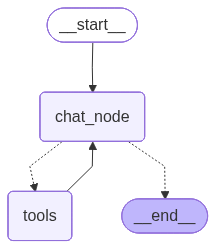

In [13]:
chatbot = graph.compile()
chatbot

In [15]:
out = chatbot.invoke({"messages": [HumanMessage(content = "Hello!")]})
print(out['messages'][-1].content)

I'm happy to help you with any questions or tasks you have. What would you like to do first?


In [16]:

# Chat requiring tool
out = chatbot.invoke({"messages": [HumanMessage(content="What is 2*3?")]})
print(out["messages"][-1].content)

The result of the operation is 6.


In [18]:
# Chat requiring tool
out = chatbot.invoke({"messages": [HumanMessage(content="What is the stock price of Tesla")]})
print(out["messages"][-1].content)

The stock price of Tesla is $485.40.


In [19]:
# Chat requiring tool
out = chatbot.invoke({"messages": [HumanMessage(content="First find out the stock price of Apple using get stock price tool then use the calculator tool to find out how much will it take to purchase 50 shares?")]})
print(out["messages"][-1].content)

It would take approximately $273.81 to purchase 1 share of Apple stock. Therefore, it would take approximately $273.81 * 50 = $13690.50 to purchase 50 shares of Apple stock.
